# Analyzing circuits

In this section, we will learn how to interpret the data that we collect from our circuits. 

### Accounting for grating couplers
Whenever data is obtained with a grating coupler, it is important to remember that the grating coupler is rensponsive to changes in wavelength as well as the circuit being tested. In order to properly interpret the data, we must first deembed the wavelength dependence of the grating coupler. This can be done in a variety of ways, including curve fitting or using a reference circuit. 

Consider the following data collected via a wavelength sweep:

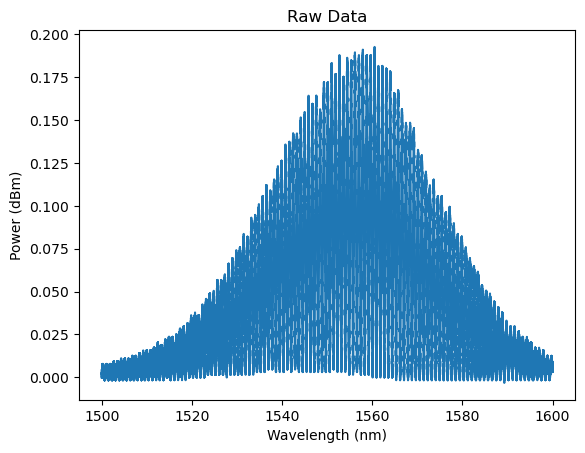

In [28]:
import numpy as np
import matplotlib.pyplot as plt

POLY_ORDER = 4

data = np.load('../files/oscope_data.npz')
wavelength = data['wavelength']
power = data['power']

# Here is the raw data from the oscilloscope
plt.plot(wavelength, power)
plt.title('Raw Data')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power (dBm)')
plt.show()

The parabolic shape of the graph is due to the grating coupler's responsivity to wavelength, which obfuscates the data from the circuit we are trying to analyze. In order to remove this effect, we curve fit the data to a parabola and subtract it from the data. 


### Curve fitting

In order to fit a curve to the data, we must first define a function that we want to fit to the data. In this case, we will use a parabola of order 4.

In [29]:
def model_parabola(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

Now, we just need to optimize the parameters of the function to fit the data. We can do this using the `curve_fit` function from `scipy.optimize`. This function takes in the function we want to fit to the data, the x and y data, and an initial guess for the parameters. It returns the optimized parameters and the covariance matrix.

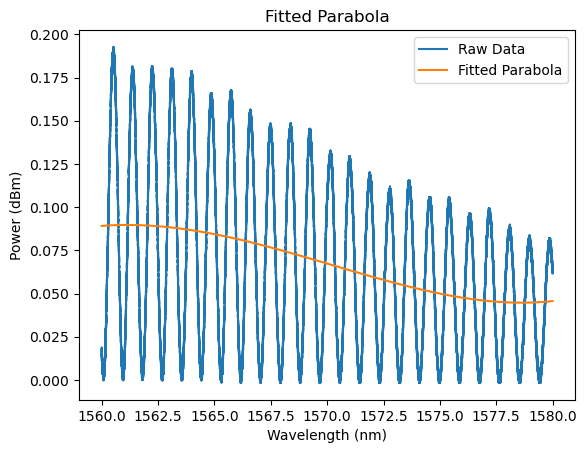

In [30]:
from scipy.optimize import curve_fit

start, end = np.argmax(wavelength > 1560), np.argmax(wavelength > 1580)
wavelength = wavelength[start:end]
power = power[start:end]

# It can be helpful in terms of speed and accuracy to add an initial guess for the optimal parameters
# This is especially true for more complicated models with more
initial_guess = [1, 1, 1, 1, 1]
optimal_parameters, covariance_matrix = curve_fit(model_parabola, wavelength, power, initial_guess) 
fit = model_parabola(wavelength, *optimal_parameters)

# Here is the data with the fitted parabola
plt.plot(wavelength, power, label='Raw Data')
plt.plot(wavelength, fit, label='Fitted Parabola')
plt.title('Fitted Parabola')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power (dBm)')
plt.legend()
plt.show()


Now, we simply subtract the curve fit from the data to obtain the data from the circuit and add an offset to the data to make it easier to see.

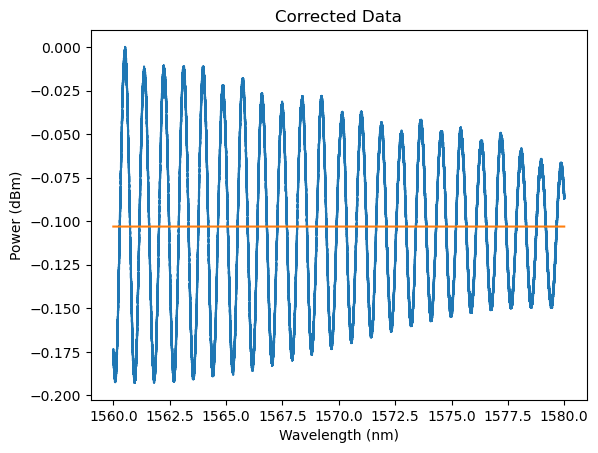

In [32]:
power_corrected = power - fit
power_corrected = power_corrected + np.max(fit) - np.max(power)

plt.plot(wavelength, power_corrected)
plt.title('Corrected Data')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power (dBm)')

plt.plot(wavelength, np.ones((len(wavelength), 1)) * np.average(power_corrected))

plt.show()


### Using a reference circuit

### Extracting the index of refraction

###  Design, Simulate, and Compare an MZI
In this section, we will walk through the process of designing an MZI in gdsfactory, simulating its behavior using sax, and finally, comparing the simulated data with data that we collect from our circuits.

To start the process, we will design an MZI using gdsfactory, we will assemble the components of an MZI in Python, leveraging the capabilities of gdsfactory to construct a detailed layout. Once the layout is finalized, Python will generate a GDS (Graphic Data System) file, encapsulating the design specifications, which we can then submit for actual fabrication.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import meep as mp
import gplugins.modes as gm
# import ipympl

import gdsfactory as gf
import ubcpdk
import ubcpdk.components as uc

gf.CONF.display_type = "klayout"

2024-04-23 13:59:01.776 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.28.0' installed at ['/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/meep']
2024-04-23 13:59:01.876 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/ubcpdk/layers.yaml'.
2024-04-23 13:59:01.894 | INFO     | ubcpdk:<module>:30 - Found UBCpdk '2.3.4' installed at PosixPath('/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/ubcpdk')
2024-04-23 13:59:01.980 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/generic_tech/layer_views.yaml'.
2024-04-23 13:59:01.986 | INFO     | gdsfactory.pdk:activate:307 - 'ubcpdk' PDK is now active


/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/cross_section.py:205: UserWarning: min_bend_radius 5 < CrossSection.radius 10.0. Increase CrossSection.radius or decrease the number of points
  warnings.warn(message)


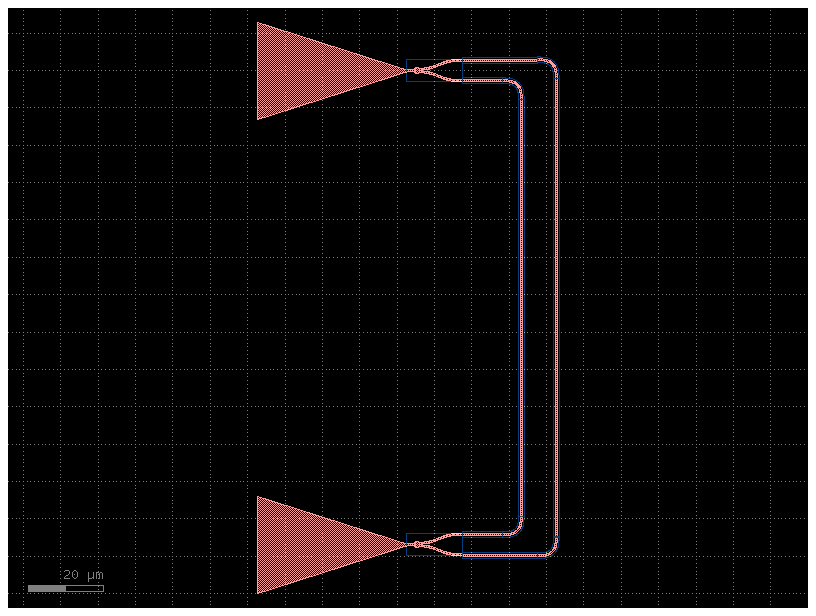

2024-04-23 13:59:02.469 | INFO     | gdsfactory.component:_write_library:1913 - Wrote to 'Sample_MZI.gds'


PosixPath('Sample_MZI.gds')

In [2]:
y_branch=uc.ebeam_y_1550()
bend = uc.bend(radius=5,p=0.75)

my_device = gf.Component(name="MyDevice")
y_in = my_device.add_ref(y_branch)
y_out = my_device.add_ref(y_branch)

short_waveguide=my_device.add_ref(uc.straight(10.8186))
long_waveguide=my_device.add_ref(uc.straight(20.299))
waveguide=my_device.add_ref(uc.straight(111.5))
short_waveguide2=my_device.add_ref(uc.straight(10.8186))
long_waveguide2=my_device.add_ref(uc.straight(20.299))
waveguide2=my_device.add_ref(uc.straight(122.5))

bend1 = my_device.add_ref(bend)
bend2 = my_device.add_ref(bend)
bend3 = my_device.add_ref(bend)
bend4 = my_device.add_ref(bend)

short_waveguide.connect('o1', y_in.ports['o3'])
bend1.connect('o2',short_waveguide.ports['o2'])
waveguide.connect('o1',bend1.ports['o1'])
bend2.connect('o2',waveguide.ports['o2'])
short_waveguide2.connect('o2',bend2.ports['o1'])
y_out.connect('o2',short_waveguide2.ports['o1'])

long_waveguide.connect('o1', y_in.ports['o2'])
bend3.connect('o2',long_waveguide.ports['o2'])
waveguide2.connect('o1',bend3.ports['o1'])
bend4.connect('o2',waveguide2.ports['o2'])
long_waveguide2.connect('o2',bend4.ports['o1'])
y_out.connect('o3',long_waveguide2.ports['o1'])

my_device.add_port(name="o1", port=y_in.ports["o1"])
my_device.add_port(name="o2", port=y_out.ports["o1"])

my_device_gc=gf.components.add_grating_couplers(component=my_device)
my_device_gc.plot()
plt.show()

my_device_gc.name="Sample_MZI"
my_device_gc.write_gds("Sample_MZI.gds")

We have successfully created the gds file for our sample MZI. Now, we will simulate the circuit. We'll utilize JAX as a subsitute for NumPy, employ matplotlib to visualize our results, and leverage SAX for building our circuit and executing simulations.

To simulate the circuit in SAX, we first create a list detailing all the parts of the MZI and how they connect. Then, we use pass parameters of waveguides using scattering parameters. We’re interested in the power transmitted from the input to the output, which is the magnitude squared of the s-parameter. 
We generate plots showing the relationship between wavelength and power using both linear and logarithmic scales.

In [3]:
from jax import config
config.update("jax_enable_x64", True)

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax
from simphony.libraries import siepic

In [5]:
mzi, info = sax.circuit(
    netlist={
        "instances": {
            "gc_in": "gc",
            "splitter": "ybranch",
            "long_wg": "waveguide",
            "short_wg": "waveguide",
            "combiner": "ybranch",
            "gc_out": "gc",
        },
        "connections": {
            "gc_in,o0": "splitter,port 1",
            "splitter,port 2": "long_wg,o0",
            "splitter,port 3": "short_wg,o0",
            "long_wg,o1": "combiner,port 2",
            "short_wg,o1": "combiner,port 3",
            "combiner,port 1": "gc_out,o0",
        },
        "ports": {
            "in": "gc_in,o1",
            "out": "gc_out,o1",
        },
    },
    models={
        "ybranch": siepic.y_branch,
        "waveguide": siepic.waveguide,
        "gc": siepic.grating_coupler,
    }
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
sax.get_settings(mzi)

{'gc_in': {'wl': 1.55, 'pol': 'te', 'thickness': 220.0, 'dwidth': 0},
 'splitter': {'wl': 1.55, 'pol': 'te', 'thickness': 220.0, 'width': 500.0},
 'long_wg': {'wl': 1.55,
  'pol': 'te',
  'length': 0.0,
  'width': 500.0,
  'height': 220.0,
  'loss': 0.0},
 'short_wg': {'wl': 1.55,
  'pol': 'te',
  'length': 0.0,
  'width': 500.0,
  'height': 220.0,
  'loss': 0.0},
 'combiner': {'wl': 1.55, 'pol': 'te', 'thickness': 220.0, 'width': 500.0},
 'gc_out': {'wl': 1.55, 'pol': 'te', 'thickness': 220.0, 'dwidth': 0}}

In [7]:
wl = jnp.linspace(1.52, 1.58, 1000)

S = mzi(wl=wl, long_wg={"length": 180.0}, short_wg={"length": 150.0})

/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


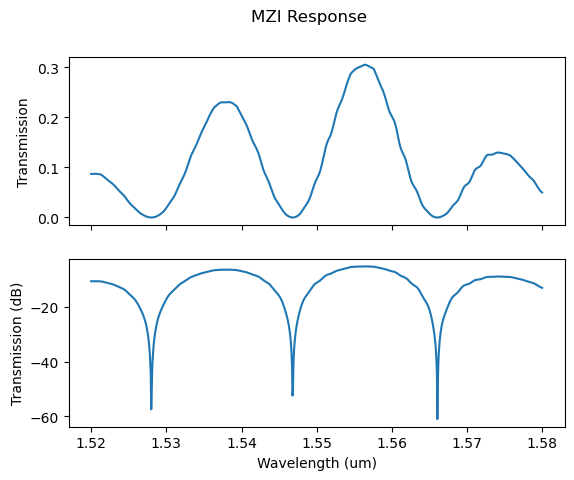

In [8]:
mag = jnp.abs(S["out", "in"])**2
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(wl, mag)
axs[0].set_ylabel("Transmission")
axs[1].plot(wl, 10*jnp.log10(mag))
axs[1].set_ylabel("Transmission (dB)")
axs[1].set_xlabel("Wavelength (um)")
plt.suptitle("MZI Response")
plt.show()

Now we have successfully simulated the MZI circuit, we will import the data that we collect from the acutal circuit and compare the results. We will use scipy package to import .mat file. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
data = scipy.io.loadmat('../files/sequoiap_MZIdL20u_478.mat')

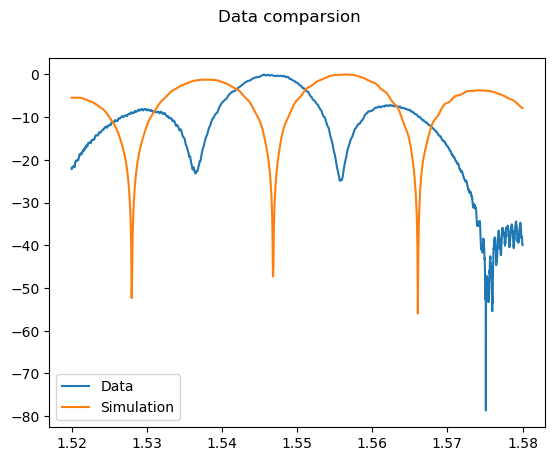

In [10]:
scan_data = data['scandata']
wl_data=scan_data[0][0][0][0]*10**6
power=scan_data[0][0][1]
power_t=np.transpose(power[:,1])-np.max(power)
mag_norm=10*jnp.log10(mag)-np.max(10*jnp.log10(mag))
plt.plot(wl_data,power_t,label="Data")
plt.plot(wl,mag_norm,label="Simulation")
plt.legend(loc="best")
plt.suptitle("Data comparsion")
plt.show()

As we can see, the simulated data doesn't align closely with the actual data obtained from the fabricated circuit. To improve this alignment, we'll adjust the width parameter. This adjustment aims to better account for potential fabrication errors, some possibilities are underdeveopling and overdeveloping, where the size the of patterned photoresist is wrong. Other possbility is over etching, where the acid remains on the photoresist for too long after it's stripped. In our case, since the width is smaller than we anticipated, it is likely overetched.

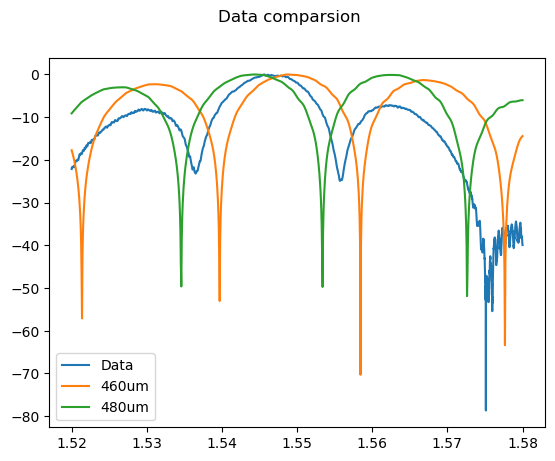

In [11]:
scan_data = data['scandata']
wl_data=scan_data[0][0][0][0]*10**6
power=scan_data[0][0][1]
power_t=np.transpose(power[:,1])-np.max(power)

S_460 = mzi(wl=wl, long_wg={"length": 180.0,"width":460,"height":220}, short_wg={"length": 150.0,"width":460,"height":220})
S_480 = mzi(wl=wl, long_wg={"length": 180.0,"width":480,"height":220}, short_wg={"length": 150.0,"width":480,"height":220})
mag_460 = jnp.abs(S_460["out", "in"])**2
mag_480 = jnp.abs(S_480["out", "in"])**2
mag_norm_460=10*jnp.log10(mag_460)-np.max(10*jnp.log10(mag_460))
mag_norm_480=10*jnp.log10(mag_480)-np.max(10*jnp.log10(mag_480))
plt.plot(wl_data,power_t,label="Data")
plt.plot(wl, mag_norm_460,label="460um")
plt.plot(wl, mag_norm_480,label="480um")
plt.legend(loc="best")
plt.suptitle("Data comparsion")
plt.show()

After adjusting the width parameter of the waveguide, we observe a more accurate match between the simulated data and the experimental results. Despite our initial design target of a 500um waveguide width, we find that the actual width ranges between 460um and 480um. This variation is likely due to fabrication inaccuracies inherent in the manufacturing process. By making these changes to the parameters, we can make our simulation model more accurate and better at predicting fabricated photonic circuits.